In [1]:
import numpy as np 

from numpy.typing import ArrayLike
from typing import Type, Union, Sequence

# Tensor and Parameter classes

In [508]:
class Tensor(np.ndarray):

    def __new__(cls, data: ArrayLike):
        obj = np.asarray(data).view(cls)
        return obj
    
    def __array_ufunc__(self, ufunc, method, *inputs, out=None, **kwargs):
        # input validation 
        Tensor._validate_inputs(inputs)
        Tensor._validate_inputs(kwargs.values())
        if out is not None: 
            Tensor._validate_inputs(out)
            
            # The subclasses of Tensor must be downcasted to np.arrays 
            out = Tensor._downcast_where_possible(out)
        args = Tensor._downcast_where_possible(inputs)
        kwargs = Tensor._downcast_where_possible(kwargs)
        results = super().__array_ufunc__(ufunc, method, *args, out=out, **kwargs)
        
        # return output Tensors if possible
        if out is not None: 
            if ufunc.nout == 1: 
                results = (results, )
            results = tuple(result if output is None else output 
                            for result, output in zip(results, out))
            if len(results) == 1: 
                results = results[0]
        
        # Upcast to Tensor 
        return Tensor._upcast_where_possible(results)
    
    def __array_function__(self, func, types, *args, **kwargs):
        """
        Somehow array_function works without the downcasting, yet also without visiting __array_ufunc__
        """
        Tensor._validate_input_types(types)
        results = super().__array_function__(func, types, *args, **kwargs)
        return Tensor._upcast_where_possible(results)
        
    @staticmethod 
    def _downcast_where_possible(iterable):
        if isinstance(iterable, dict):
            return dict(zip(iterable.keys(), Tensor._downcast_where_possible(iterable.values())))
        return tuple(item.view(np.ndarray) if issubclass(type(item), np.ndarray) else item
                     for item in iterable)
        
    @staticmethod
    def _upcast_where_possible(results):
        """
        If the result is an np.ndarray subclass, return a Tensor. If it is an iterable, return it with all 
        subclasses of np.ndarray casted to Tensor. 
        """
        # np.array subclass
        if issubclass(type(results), np.ndarray):
            return results.view(Tensor)
        # Iterable
        try: 
            return type(results)(
                result.view(Tensor) if issubclass(type(result), np.ndarray) else result 
                for result in results
            )   
        # single, non-iterable object - turn to Tensor
        except: 
            return Tensor(results)
        
    @staticmethod
    def _validate_inputs(inputs: Sequence):
        types = map(type, inputs) 
        Tensor._validate_input_types(types)
        
    @staticmethod 
    def _validate_input_types(types):
        """
        Does not accept np.ndarray superclasses 
        """
        if any(issubclass(Tensor, type_) and not Tensor is type_ for type_ in types):
            raise NotImplemented
        

In [535]:
class Parameter(Tensor):
    """
    Does not override __array_function__ or __array_ufunc__, since we do not want operations on Parameters 
    to produce new Parameters.
    
    TODO: Consider whether requires_grad should not always be True, we have Tensors 
    for objects that do not have gradients.
    """
    def __new__(cls, data: Tensor, requires_grad: bool = True):
        obj = data.view(cls)
        
        # At this point __array_finalize__ has once been executed via the view method; thus, 
        # if the object is instantiated via constructor, it already has _grad = None
        if requires_grad is True: 
            obj._grad = Tensor(np.zeros(obj.shape))
        return obj
    
    def __array_finalize__(self, obj):
        if obj is None: return 
        self._grad = getattr(obj, '_grad', None)
    
    @property
    def grad(self) -> Tensor:
        return self._grad
    
    @grad.setter
    def grad(self, dx: Tensor):
        assert dx.shape == self.shape 
        self._grad = dx
        
    def zero_grad(self):
        self.grad = Tensor(np.zeros(self.shape))
    
    def optimize(self, dx: Tensor, *, maximize: bool = False):
        """
        Final optimization step deffered to the Parameter itself. Reason being that we might 
        want to implement Parameter subclasses with their own constraints on the descent/ascent steps. 
        """
        if maximize is True: 
            self += dx 
        else: 
            self -= dx 

    def __repr__(self):
        return f"{super().__repr__()} with gradient: {repr(self.grad)}"

In [118]:
foo = Tensor([0, 0, 0, 0, 0, 0])

np.concatenate((Tensor([1, 2, 3]), Tensor([4, 5, 6])), out=foo), foo

(Tensor([1, 2, 3, 4, 5, 6]), Tensor([1, 2, 3, 4, 5, 6]))

In [119]:
foo = Tensor([1, 2]).astype(float)
foo = foo + 1
foo += 1
foo

Tensor([3., 4.])

In [128]:
def test_parameter():
    bar = Parameter(Tensor([1, 2])).astype(float)
    bar.grad += 1
    car = bar.copy() 
    car -= bar.grad 
    bar.optimize(Tensor([1., 1.]))
    assert tuple(bar) == (0.0, 1.0)
    assert tuple(bar.grad) == (1.0, 1.0)
    assert isinstance(car, Tensor)
    bar.zero_grad()
    assert tuple(bar.grad) == (0.0, 0.0)
    
test_parameter()

# Module with parameter registration

In [285]:
from abc import ABC, abstractmethod
from typing import Any, Tuple, Iterator

class Module(ABC):
    
    def __init__(self):
        self._parameters = None
        self._modules = None

    @abstractmethod
    def forward(self, *args, **kwargs) -> Any:
        ...

    @abstractmethod
    def backward(self, *args, **kwargs) -> Any:
        ...

    def __call__(self, *args, **kwargs) -> Any:
        return self.forward(*args, **kwargs)
    
    def named_modules(self, recurse: bool = True) -> Iterator[Tuple[str, Module]]:
        """
        Generates submodules and their names of this Module object in the order in which they appear 
        in the __dict__ attribute. If recurse is True then subsubmodules of submodules etc. until reaching 
        submodules with no subsubmodules. 
        """
        if self._modules is None:
            self._register_modules_from_attributes()
        for name, module in self._modules.items():
            yield name, module
            if recurse is True:
                for subname, submodule in module.named_modules():
                    yield f"{name}.{subname}", submodule
                    
    def modules(self, recurse: bool = True) -> Iterator[Module]:
        for _, module in self.named_modules(recurse=recurse): 
            yield module

    def named_parameters(self, recurse: bool = True) -> Iterator[Tuple[str, Parameter]]:
        if self._parameters is None:
            self._register_parameters_from_attributes()
        for name, param in self._parameters.items():
            yield name, param
        if recurse is True:
            for module_name, module in self.named_modules(recurse=False):
                for param_name, param in module.named_parameters(recurse=True):
                    yield f"{module_name}.{param_name}", param
                    
    def parameters(self, recurse: bool = True) -> Iterator[Parameter]:
        for _, parameter in self.named_parameters(recurse=recurse):
            yield parameter

    def _register_modules_from_attributes(self) -> None:
        self._modules = {attr: val for attr, val in self.__dict__.items()
                         if issubclass(type(val), Module)}

    def _register_parameters_from_attributes(self) -> None:
        self._parameters = {attr: val for attr, val in self.__dict__.items() 
                            if issubclass(type(val), Parameter)}
                

In [286]:
class Add(Module):
    """
    Addition operation between two Tensors.
    """
    def __init__(self) -> None:
        super().__init__()

    def forward(self, x1: Tensor, x2: Tensor) -> Tensor:
        return x1 + x2

    def backward(self, dy: Tensor) -> Tuple[Tensor, Tensor]:
        return dy, dy
    
    
class MatMul(Module):
    """
    Matrix multiplication of two Tensors.
    """
    def __init__(self):
        super().__init__()
        self.x1: Tensor = None
        self.x2: Tensor = None

    def forward(self, x1: Tensor, x2: Tensor) -> Tensor:
        self.x1 = x1
        self.x2 = x2
        return self.x1 @ self.x2

    def backward(self, dy: Tensor) -> Tuple[Tensor, Tensor]:
        dx1 = dy @ self.x2.T
        dx2 = self.x1.T @ dy
        return dx1, dx2

In [287]:
import numpy as np


rng = np.random.default_rng()

def normal(shape, mean: float = 0.0, std: float = 1.0):
    return rng.normal(loc=mean, scale=std, size=shape)


class Linear(Module):

    def __init__(self, in_features: int, out_features: int, bias: bool = True):
        super().__init__()
        
        self.in_features = in_features
        self.out_features = out_features
        
        self.weights = Parameter(normal((self.out_features, self.in_features)))
        self.matmul = MatMul()
        
        if bias is True:
            self.bias = Parameter(normal((self.out_features, 1))) if bias else None
            self.add = Add()
            
    def forward(self, x):
        y = self.matmul(self.weights, x)
        if self.bias is not None: 
            y = self.add(self.bias, y)
        return y

    def backward(self, dy):
        if self.bias is not None:
            db, dy = self.add.backward(dy)
            self.bias.grad += db
            
        dw, dx = self.matmul.backward(dy)
        self.weights.grad += dw
        return dx

In [288]:
class MLP(Module):
    
    def __init__(self, in_features: int, hidden_features: int, out_features: int, bias: bool = True):
        super().__init__()
        self.lin1 = Linear(in_features, hidden_features, bias=bias)
        self.lin2 = Linear(hidden_features, out_features, bias=bias)
    
    def forward(self, x):
        x = self.lin1(x)
        y = self.lin2(x)
        return y
    
    def backward(self, dy):
        dy = self.lin2.backward(dy=dy)
        dx = self.lin1.backward(dy=dy)
        return dx 

In [289]:
class MMLP(Module):
    
    def __init__(self, features1, features2, bias: bool = True):
        super().__init__()
        self.mlp1 = MLP(*features1, bias)
        self.mlp2 = MLP(*features2, bias)
        
    def forward(self, x):
        x = self.mlp1(x)
        y = self.mlp2(x)
        return y
    
    def backward(self, dy):
        dy = self.mlp2.backward(dy)
        dx = self.mlp1.backward(dy)
        return dx

In [300]:
model = Linear(1, 2)

for name, parameter in model.named_parameters(): 
    print(f"{name=}, {parameter=}")
    
for name, module in model.named_modules():
    print(f"{name=}, {module=}")

name='weights', parameter=Parameter([[-0.49431333],
           [ 0.17091917]])
name='bias', parameter=Parameter([[ 0.69337367],
           [-0.38871296]])
name='matmul', module=<__main__.MatMul object at 0x00000183F8AA1C10>
name='add', module=<__main__.Add object at 0x00000183F8AA1580>


In [303]:
model(Tensor([[1.0]])), model.backward(Tensor([[1.0], [1.0]]))

(Tensor([[ 0.19906035],
         [-0.21779379]]),
 Tensor([[-0.32339416]]))

# Optimizer class

In [485]:
from typing import Union


class Optimizer(ABC):
    
    def __init__(self, params: Union[Iterator[Tuple[str, Parameter]], Dict[str, Any]], 
                 **defaults):
        self.param_groups = Optimizer._group_params(params=params, defaults=defaults)
         
    def _group_params(params, defaults: Union[dict, None] = None) -> list[dict]:
         # Convert iterable of parameters into list of dictionaries
        param_groups = list(params) 
        if all(isinstance(item, Parameter) for item in param_groups):
            param_groups = [{'params': param_groups}]
            
        # Convert single Parameters into a list of one Parameter and other iterables into lists 
        for param_group in param_groups:   
            params = param_group['params']
            if isinstance(params, Parameter):
                params = [params]
            else:
                params = list(params)
                if len(params) == 0:
                    raise ValueError("Empty parameter list passed to Optimizer")
            param_group['params'] = params
            
        # Add defaults if present 
        if defaults is not None: 
            for param_group in param_groups:
                keys_present = param_group.keys() 
                param_group.update({key: val for key, val in defaults.items()
                                    if key not in keys_present})
        return param_groups
        
    @abstractmethod 
    def step(self):
        ... 
    
    def zero_grad(self) -> None:
        for param_group in self.param_groups:
            for param in param_group['params']:
                param.zero_grad()

In [657]:
from typing import Callable


class LRScheduler(ABC):
    
    def __init__(self, epoch: int = -1) -> None:
        self.epoch = epoch
    
    def step(self, lr: float) -> float:
        self.epoch += 1
        if self.epoch == 0:
            return self._setup(lr=lr)
        else:
            return self._step(lr=lr)
        
    @abstractmethod 
    def _step(self, lr: float) -> float: 
        ...
        
    def _setup(self, lr: float) -> float: 
        return lr 
    
    
class LambdaLR(LRScheduler):
    """
    Always returns initial learning rate times lr_lambda(epoch). 
    """
    
    def __init__(self, lr_lambda: Callable[[int], float], epoch: int = -1) -> None:
        super().__init__(epoch=epoch)
        self.lr_lambda = lr_lambda
        self.base_lr: Union[float, None] = None

    def _step(self, lr: float) -> float: 
        return self.base_lr * self.lr_lambda(self.epoch)
    
    def _setup(self, lr: float) -> float: 
        self.base_lr = lr
        return lr
    

class MultiplicativeLR(LRScheduler):
    
    def __init__(self, lr_lambda: Callable[[int], float], epoch: int = -1) -> None:
        super().__init__(epoch=epoch)
        self.lr_lambda = lr_lambda
    
    def _step(self, lr: float) -> float: 
        return lr * self.lr_lambda(self.epoch)
        
    
class StepLR(LRScheduler):
    
    # TODO perhaps rename step_size to step_epochs 
    def __init__(self, step_size: int, gamma: float = 0.1, epoch: int = -1) -> None: 
        super().__init__(epoch=epoch)
        self.step_size = step_size 
        self.gamma = gamma 
    
    def _step(self, lr: float) -> float: 
        if self.epoch % self.step_size == 0: 
            return lr * self.gamma 
        return lr 

In [658]:
from functools import reduce 


class LROptimizer(Optimizer):
    
    def __init__(self, params: Union[Iterator[Tuple[str, Parameter]], Dict[str, Any]], lr: float, 
                 lr_schedulers: Union[list[LRScheduler], LRScheduler, None] = None, 
                 **defaults: dict[str, Any]) -> None:
        super().__init__(params=params, lr=lr, lr_schedulers=lr_schedulers, **defaults)
        self._prep_lr_schedulers()
        self.schedule_lr()
         
    def _prep_lr_schedulers(self) -> None:
        """
        Ensures that the 'lr_schedulers' attributes of each param_group is a list. 
        """
        for param_group in self.param_groups:
            lr_schedulers = param_group['lr_schedulers']
            # TODO another solution would be to have an identity scheduler class and set it here 
            if lr_schedulers is None: 
                continue 
            elif isinstance(lr_schedulers, LRScheduler):
                lr_schedulers = [lr_schedulers]
            else:
                lr_schedulers = list(lr_schedulers)
            param_group['lr_schedulers'] = lr_schedulers
        
    @abstractmethod
    def step(self) -> None:
        ... 
        
    def schedule_lr(self) -> None:
        """
        Applies all lr_schedulers in a given param_group to the learning rate of that group.
        """
        for param_group in self.param_groups:
            lr_schedulers = param_group['lr_schedulers']
            # It is possible that one param group has a scheduler, while another does not
            if lr_schedulers is not None:
                param_group['lr'] = reduce(
                    lambda lr, lr_scheduler: lr_scheduler.step(lr), 
                    param_group['lr_schedulers'], 
                    param_group['lr'],
                )

In [804]:
class SGD(LROptimizer):
    def __init__(self, params, lr: float, 
                 lr_schedulers: Union[list[LRScheduler], LRScheduler, None] = None, 
                 momentum: float = 0, dampening: float = 0, weight_decay: float = 0, 
                 nesterov: bool = False, *, maximize: bool = False):
        super().__init__(params=params, lr=lr, lr_schedulers=lr_schedulers, momentum=momentum, 
                         dampening=dampening, weight_decay=weight_decay, nesterov=nesterov, 
                         maximize=maximize)
        # store exponential moving average of the gradient if using momentum
        for param_group in self.param_groups:
            param_group['grads_ema'] = [param.grad if momentum != 0 else None 
                                        for param in param_group['params']]
            
    def step(self):
        for param_group in self.param_groups:
            lr, momentum, dampening, weight_decay, nesterov, maximize = param_group['lr'], \
            param_group['momentum'], param_group['dampening'], param_group['weight_decay'], \
            param_group['nesterov'], param_group['maximize']
            for param, grad_ema in zip(param_group['params'], param_group['grads_ema']):
                SGD.sgd(param=param, grad_ema=grad_ema, lr=lr, momentum=momentum, dampening=dampening, 
                       weight_decay=weight_decay, nesterov=nesterov, maximize=maximize)
                
                
    @staticmethod
    def sgd(param: Parameter, grad_ema: list[Tensor], lr: float, momentum: float = 0, dampening: float = 0, 
            weight_decay: float = 0, nesterov: bool = False, *, maximize: bool = False) -> None:
        """
        Applies Stochastic Gradient Descent (or Ascent) on a given Parameter.
        
        TODO: consider whether copy should be optional to save space. 
        """
        grad = param.grad.copy()
        # L2 penalty 
        if weight_decay != 0:
            grad += weight_decay * param 
        # momentum 
        if momentum != 0:
            grad_ema = momentum * grad_ema + (1 - dampening) * grad 
        # Adjustment for Nesterov's version of momentum SGD
        if nesterov is True: 
            grad += momentum * grad_ema 
        # Apply learning rate 
        param.optimize(grad * lr, maximize=maximize)

In [819]:
model = Linear(1, 2)
optimizer = SGD(model.parameters(), 0.01, lr_schedulers=StepLR(2, 0.1), momentum=0.9, dampening=0, 
                weight_decay=0.2, nesterov=True, 
                maximize=True)
model(Tensor([[1.0]]))
model.backward(Tensor([[1.0], [1.0]]))
optimizer.param_groups

[{'params': [Parameter([[-0.42285552],
              [-0.56282902]]) with gradient: Tensor([[1.],
           [1.]]),
   Parameter([[-0.65307242],
              [ 0.53625914]]) with gradient: Tensor([[1.],
           [1.]])],
  'lr': 0.01,
  'lr_schedulers': [<__main__.StepLR at 0x183fce5beb0>],
  'momentum': 0.9,
  'dampening': 0,
  'weight_decay': 0.2,
  'nesterov': True,
  'maximize': True,
  'grads_ema': [Tensor([[1.],
           [1.]]),
   Tensor([[1.],
           [1.]])]}]

In [820]:
optimizer.schedule_lr()
optimizer.param_groups

[{'params': [Parameter([[-0.42285552],
              [-0.56282902]]) with gradient: Tensor([[1.],
           [1.]]),
   Parameter([[-0.65307242],
              [ 0.53625914]]) with gradient: Tensor([[1.],
           [1.]])],
  'lr': 0.01,
  'lr_schedulers': [<__main__.StepLR at 0x183fce5beb0>],
  'momentum': 0.9,
  'dampening': 0,
  'weight_decay': 0.2,
  'nesterov': True,
  'maximize': True,
  'grads_ema': [Tensor([[1.],
           [1.]]),
   Tensor([[1.],
           [1.]])]}]

In [821]:
for param in model.parameters():
    print(repr(param))

Parameter([[-0.42285552],
           [-0.56282902]]) with gradient: Tensor([[1.],
        [1.]])
Parameter([[-0.65307242],
           [ 0.53625914]]) with gradient: Tensor([[1.],
        [1.]])


In [822]:
optimizer.step()
for param in model.parameters():
    print(repr(param))

Parameter([[-0.39736238],
           [-0.53786777]]) with gradient: Tensor([[1.],
        [1.]])
Parameter([[-0.6284541 ],
           [ 0.56539692]]) with gradient: Tensor([[1.],
        [1.]])


In [823]:
optimizer.zero_grad()
for param in model.parameters():
    print(param, param.grad)

[[-0.39736238]
 [-0.53786777]] [[0.]
 [0.]]
[[-0.6284541 ]
 [ 0.56539692]] [[0.]
 [0.]]


# Example of everything together 

In [685]:
class MSELoss(Module):

    def __init__(self):
        self.x = None
        self.x_hat = None

    def forward(self, x, x_hat):
        self.x = x
        self.x_hat = x_hat
        return np.mean((x - x_hat) ** 2, keepdims=True)

    def backward(self, dy=1):
        return 2 * (self.x_hat - self.x) / len(self.x) * dy

In [800]:
inputs = [Tensor(normal(shape=(2, 1))) for i in range(100)]
targets = [t * 2 for t in inputs]

In [801]:
model1 = Linear(2, 2)
model2 = Linear(2, 2)
model2.weights = model1.weights.copy() 
model2.bias = model1.bias.copy()

In [802]:
optimizer = SGD(model1.parameters(), lr=0.01, lr_schedulers=None, momentum=0, dampening=0, 
                weight_decay=0, nesterov=False, maximize=False)
criterion = MSELoss()

EPOCHS = 10
total_loss_1 = []
for epoch in range(EPOCHS):
    for input, target in zip(inputs, targets):
        output = model1(input)
        loss = criterion(target, output)
        model1.backward(criterion.backward())
        optimizer.step()
        optimizer.zero_grad()
        print(f"Epoch: {epoch+1}, loss: {loss.item()}", end='\r')
        total_loss_1.append(loss.item())
    optimizer.schedule_lr()

In [824]:
optimizer = SGD(model2.parameters(), lr=0.01, lr_schedulers=None, momentum=0.9, dampening=0, 
                weight_decay=0, nesterov=False, maximize=False)
criterion = MSELoss()

EPOCHS = 10
total_loss_2 = []
for epoch in range(EPOCHS):
    for input, target in zip(inputs, targets):
        output = model2(input)
        loss = criterion(target, output)
        model2.backward(criterion.backward())
        optimizer.step()
        optimizer.zero_grad()
        print(f"Epoch: {epoch+1}, loss: {loss.item()}", end='\r')
        total_loss_2.append(loss.item())
    optimizer.schedule_lr()

In [795]:
optimizer.param_groups

[{'params': [Parameter([[1.99987928e+00, 3.75557679e-05],
              [1.92420724e-04, 1.99984504e+00]]) with gradient: Tensor([[0., 0.],
           [0., 0.]]),
   Parameter([[5.26429666e-07],
              [6.59687275e-05]]) with gradient: Tensor([[0.],
           [0.]])],
  'lr': 0.01,
  'lr_schedulers': None,
  'momentum': 0.9,
  'dampening': 0,
  'weight_decay': 0,
  'nesterov': False,
  'maximize': False,
  'grads_ema': [Tensor([[-3.21468088,  0.32562826],
           [-3.01793891,  0.30569945]]),
   Tensor([[-1.75592288],
           [-1.64845849]])]}]

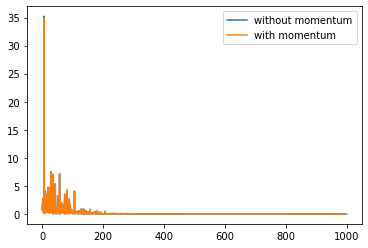

In [796]:
from matplotlib import pyplot as plt

plt.plot(total_loss_1, label='without momentum')
plt.plot(total_loss_2, label='with momentum')
plt.legend()

In [716]:
list(model.named_parameters())

[('weights',
  Parameter([[-0.77913514,  1.86313789],
             [ 0.67635851, -0.2000684 ],
             [ 0.14666837, -0.06879656]]) with gradient: Tensor([[0., 0.],
          [0., 0.],
          [0., 0.]])),
 ('bias',
  Parameter([[ 1.00000000e+00],
             [ 8.89586397e-31],
             [-1.00000000e+00]]) with gradient: Tensor([[0.],
          [0.],
          [0.]]))]

In [ ]:
from functools import reduce 


class LrOptimizer(Optimizer):
    
    def __init__(self, params: Union[Iterator[Tuple[str, Parameter]], Dict[str, Any]], 
                 **defaults):
        self.param_groups = Optimizer._group_params(params=params, defaults=defaults)
         
    def _group_params(params, defaults: Union[dict, None] = None) -> list[dict]:
         # Convert iterable of parameters into list of dictionaries
        param_groups = list(params) 
        if all(isinstance(item, Parameter) for item in param_groups):
            param_groups = [{'params': param_groups}]
            
        # Convert single Parameters into a list of one Parameter and other iterables into lists 
        for param_group in param_groups:   
            params = param_group['params']
            if isinstance(params, Parameter):
                params = [params]
            else:
                params = list(params)
                if len(params) == 0:
                    raise ValueError("Empty parameter list passed to Optimizer")
            param_group['params'] = params
            
        # Add defaults if present 
        if defaults is not None: 
            for param_group in param_groups:
                keys_present = param_group.keys() 
                param_group.update({key: val for key, val in defaults.items()
                                    if key not in keys_present})
        return param_groups
        
    @abstractmethod 
    def step(self) -> None:
        ... 
        
    def schedule_lr(self) -> None:
        """
        Still need to convert lr_schedulers into a list 
        """
        for param_group in self.param_groups:
            if 'lr_schedulers' in param_group.keys():
                param_group['lr'] = reduce(
                    lambda lr, lr_scheduler: lr_scheduler.step(lr), 
                    param_group['lr_schedulers'], 
                    param_group['lr'],
                )
    
    def zero_grad(self) -> None:
        for param_group in self.param_groups:
            for param in param_group['params']:
                param.zero_grad()

In [677]:
optimizer.param_groups

[{'params': [Parameter([[ 1.67057228,  1.87517728],
              [ 0.13839523, -1.03497162],
              [-0.80922372, -0.29975701]]) with gradient: Tensor([[0., 0.],
           [0., 0.],
           [0., 0.]]),
   Parameter([[-0.25474946],
              [-1.51037068],
              [-0.17723706]]) with gradient: Tensor([[0.],
           [0.],
           [0.]])],
  'lr': 0.01,
  'lr_schedulers': None,
  'momentum': 0,
  'dampening': 0.1,
  'weight_decay': 0,
  'nesterov': True,
  'maximize': False,
  'grads_ema': None}]